In [1]:
import torch
import torchvision

torch.cuda.is_available()

True

## Data

In [2]:
# possibly use transform that preprocesses later, rather than default 
celeba_train = torchvision.datasets.CelebA(root="data/", split="train", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
celeba_valid = torchvision.datasets.CelebA(root="data/", split="valid", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
# celeba_test = torchvision.datasets.CelebA(root="data/", split="test", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
train_data_loader = torch.utils.data.DataLoader(celeba_train,
                                          batch_size=16,
                                          shuffle=False, # Should be True later
                                          num_workers=1)

In [ ]:
iter_loader = iter(train_data_loader)

In [60]:
s = next(iter_loader)
len(s[0])

16

### DataLoader Experiment

In [29]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.triplets = self.generate_triplets()  # Precompute the triplets

    def generate_triplets(self):
        # Implement your triplet generation logic here
        # This is just a placeholder example
        triplets = []
        for i in range(len(self.dataset)):
            triplets.append((i, (i+1)%len(self.dataset), (i+2)%len(self.dataset)))
        return triplets

    def __getitem__(self, index):
        a, p, n = self.triplets[index]
        # print(f"Getting item {a, p, n}")
        return self.dataset[a], self.dataset[p], self.dataset[n]

    def __len__(self):
        print(f"len(self.dataset)={len(self.dataset)}")
        return len(self.dataset)

# Use the custom dataset with the DataLoader
triplet_dataset = TripletDataset(celeba_train)
triplet_data_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=32, shuffle=False, num_workers=0)

In [33]:
triplet_it = iter(triplet_data_loader)
# Assuming triplet_sample is a tuple of PIL Images or tensors
img_batch = next(triplet_it)
len(img_batch[0][1])
# (anchor, al), (positive, pl), (negative, nl) = img_batch[0]
# anchor, positive, negative = img_batch[0]
# plt.imshow(anchor)
# print(anchor.shape)

len(self.dataset)=162770


32

### DataLoader

In [53]:
# Custom sampler class that generates batches with of triplets of images
class TripletSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for i in range(len(self.dataset)):
            # print("sampler:",i)
            # Get a random anchor image and its identity
            anchor_img, anchor_identity = self.dataset[i]
            # Get all indexes with the same identity
            same_identity_idx = torch.where(self.dataset.identity == anchor_identity)[0]
            # remove the anchor image from the list
            same_identity_idx = same_identity_idx[same_identity_idx != i]
            # Get a random positive image
            positive_idx = same_identity_idx[torch.randint(len(same_identity_idx), (1,))]
            # Get all indexes with different identities
            different_identity_idx = torch.where(self.dataset.identity != anchor_identity)[0]
            # Get a random negative image
            negative_idx = different_identity_idx[torch.randint(len(different_identity_idx), (1,))]

            yield (i, positive_idx, negative_idx)

    def __len__(self):
        return len(self.dataset)


# class TripletBatchSampler(torch.utils.data.sampler.BatchSampler):
#     def __init__(self, sampler, batch_size, drop_last):
#         super(TripletBatchSampler, self).__init__(sampler, batch_size, drop_last)

#     def __iter__(self):
#         batch = []
#         for idx in self.sampler:
#             batch.append(idx)
#             if len(batch) == self.batch_size:
#                 yield batch
#                 batch = []
#         if len(batch) > 0 and not self.drop_last:
#             yield batch


class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, triplet_idx):
        print(triplet_idx)
        anchor_idx, positive_idx, negative_idx = triplet_idx
        anchor = self.dataset[anchor_idx]
        positive = self.dataset[positive_idx]
        negative = self.dataset[negative_idx]
        return anchor, positive, negative
        # return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)


def collate_fn(batch):
    # Transpose the batch from [P, N, ...] to [N, P, ...]
    # return list(zip(*batch))
    return batch


triplet_sampler = TripletSampler(celeba_train)
# triplet_batchsampler = TripletBatchSampler(triplet_sampler, batch_size=16, drop_last=False)
triplet_dataset = TripletDataset(celeba_train)

# triplet_batchsampler = torch.utils.data.BatchSampler(TripletSampler(celeba_train), batch_size=16, drop_last=False)
triplet_data_loader = torch.utils.data.DataLoader(triplet_dataset,
                                                  batch_size=16,
                                                #   shuffle=False, # Should be True later
                                                  num_workers=0,
                                                  sampler=triplet_sampler,
                                                #   batch_sampler=triplet_batchsampler
                                                  collate_fn=collate_fn
                                                    )
                                          

In [55]:
tdl = iter(triplet_data_loader)

In [56]:
b = next(tdl)
# print(len(b), b[0].shape, b[1].shape, b[0][0].shape)
print(len(b), type(b))

(0, tensor([49141]), tensor([131819]))
(1, tensor([99876]), tensor([56246]))
(2, tensor([61068]), tensor([90916]))
(3, tensor([108896]), tensor([125067]))
(4, tensor([120054]), tensor([26096]))
(5, tensor([107337]), tensor([50852]))
(6, tensor([13637]), tensor([139200]))
(7, tensor([38159]), tensor([23808]))
(8, tensor([103955]), tensor([148779]))
(9, tensor([118244]), tensor([5550]))
(10, tensor([28177]), tensor([1619]))
(11, tensor([154433]), tensor([70842]))
(12, tensor([60708]), tensor([64910]))
(13, tensor([82007]), tensor([162289]))
(14, tensor([72070]), tensor([97091]))
(15, tensor([39408]), tensor([63629]))
16 <class 'list'>


In [ ]:
import matplotlib.pyplot as plt


(anchor, al), (positive, pl), (negative, nl) = tdl


# Convert tensors to numpy arrays for visualization
if torch.is_tensor(anchor):
    anchor = anchor.permute(1, 2, 0).numpy()
    positive = positive.permute(1, 2, 0).numpy()
    negative = negative.permute(1, 2, 0).numpy()

# Create a subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Show the images
axs[0].imshow(anchor)
axs[0].set_title('Anchor')

axs[1].imshow(positive)
axs[1].set_title('Positive')

axs[2].imshow(negative)
axs[2].set_title('Negative')

# Remove the axis
for ax in axs:
    ax.axis('off')

plt.show()

In [186]:
import numpy as np

def make_triplets(img_batch, identity_batch, num_triplets=3):
    # imgs: tensor of shape (batch_size, 3, 218, 178)
    # labels: tensor of shape (batch_size, 1)
    # num_triplets: int
    # returns: (tensor of shape (num_triplets, 3, 218, 178),
    #          tensor of shape (num_triplets))
    triplets = []
    anchor_labels = []
    positive_labels = []
    negative_labels = []
    for i in range(num_triplets):
        # Pick a random anchor
        anchor_idx = np.random.randint(0, len(img_batch))
        anchor = img_batch[anchor_idx]
        anchor_label = identity_batch[anchor_idx]
        anchor_labels.append(anchor_label)
        
        # Pick a random positive example, with the same label as the anchor
        positive_idx = np.random.choice(np.where(identity_batch == anchor_label)[0])
        positive = img_batch[positive_idx]
        positive_label = identity_batch[positive_idx]
        positive_labels.append(positive_label)
        
        
        # Pick a random negative example with a different label from the anchor
        negative_idx = np.random.choice(np.where(identity_batch != anchor_label)[0])
        negative = img_batch[negative_idx]
        negative_label = identity_batch[negative_idx]
        negative_labels.append(negative_label)
        
        triplets.append([anchor, positive, negative])

In [143]:
train_features, train_labels = next(iter(train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {celeba_train.identity}")

Feature batch shape: torch.Size([16, 3, 218, 178])
Labels batch shape: tensor([[2880],
        [2937],
        [8692],
        ...,
        [7391],
        [8610],
        [2304]])


labels: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']
attributes: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])
identity: tensor([2880])


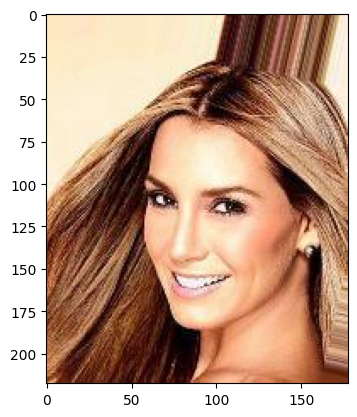

In [130]:
import matplotlib.pyplot as plt
plt.imshow(train_features[0].permute(1, 2, 0))
# torchvision.utils.imshow(train_features[0])
print("labels:", celeba_train.attr_names)
print("attributes:", celeba_train.attr[0])
print("identity:", celeba_train.identity[0])
plt.show()

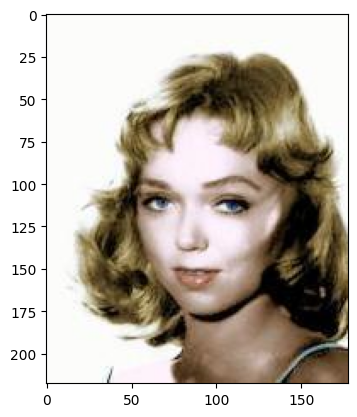

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]))

In [56]:
import matplotlib.pyplot as plt
plt.imshow(celeba_train[-1][0])
plt.show()

TypeError: pic should be PIL Image. Got <class 'torch.Tensor'>

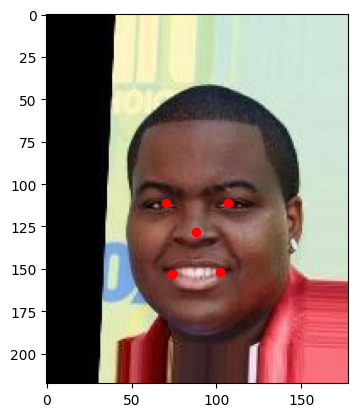

In [174]:
plt.imshow(celeba_train[-2][0].permute(1, 2, 0))

l1 = []
l2 = []
for i in range(0, len(celeba_train.landmarks_align[-1]), 2):
    l1.append(celeba_train.landmarks_align[-1][i])
    l2.append(celeba_train.landmarks_align[-1][i+1])

plt.plot(l1, l2, 'ro')
img_tensor = torchvision.transforms.Compose([ 
    torchvision.transforms.PILToTensor() 
])(celeba_train[-1][0])

print(celeba_train.bbox[-2][None,:])

# torchvision.utils.draw_bounding_boxes(img_tensor, celeba.bbox[-2])
# plt.plot([celeba.bbox[-2][1], celeba.bbox[-2][3]], [celeba.bbox[-2][0], celeba.bbox[-2][2]], 'bo')
plt.show()

tensor([32])
[('5_o_Clock_Shadow', False), ('Arched_Eyebrows', True), ('Attractive', True), ('Bags_Under_Eyes', False), ('Bald', False), ('Bangs', False), ('Big_Lips', False), ('Big_Nose', False), ('Black_Hair', False), ('Blond_Hair', True), ('Blurry', False), ('Brown_Hair', False), ('Bushy_Eyebrows', False), ('Chubby', False), ('Double_Chin', False), ('Eyeglasses', False), ('Goatee', False), ('Gray_Hair', False), ('Heavy_Makeup', True), ('High_Cheekbones', True), ('Male', False), ('Mouth_Slightly_Open', True), ('Mustache', False), ('Narrow_Eyes', False), ('No_Beard', True), ('Oval_Face', True), ('Pale_Skin', False), ('Pointy_Nose', True), ('Receding_Hairline', False), ('Rosy_Cheeks', True), ('Sideburns', False), ('Smiling', True), ('Straight_Hair', False), ('Wavy_Hair', False), ('Wearing_Earrings', True), ('Wearing_Hat', False), ('Wearing_Lipstick', True), ('Wearing_Necklace', False), ('Wearing_Necktie', False), ('Young', True)]


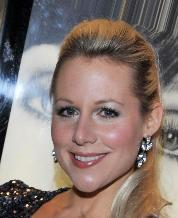

In [14]:
index = 123456
print(celeba_train.identity[index])
attr_bools = [bool(x) for x in celeba_train.attr[index]]
print(list(zip(celeba_train.attr_names, attr_bools)))
celeba_train[index][0]

Max number of images for a single identity: 35
Number of identities with only one image: 44


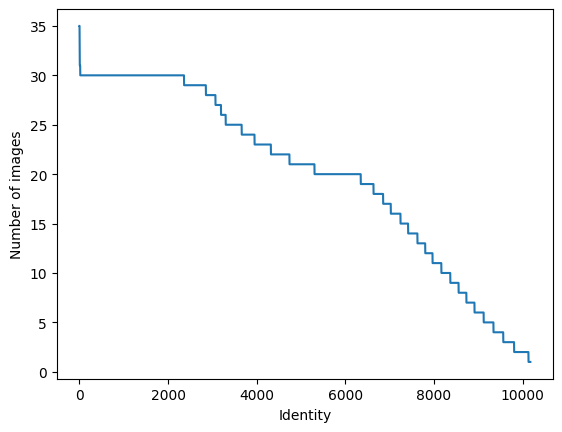

In [15]:
# Make a plot of the identities, where x-axis is the identity, sorted by number of images, and y-axis is the number of images in the dataset
from matplotlib import pyplot as plt
from collections import Counter

identity_batch = [celeba_train.identity[i].item() for i in range(len(celeba_train))]
counts = Counter(identity_batch)
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

print("Max number of images for a single identity:", sorted_counts[0][1])
print("Number of identities with only one image:", sum([1 for x in sorted_counts if x[1] == 1]))

plt.plot([x[1] for x in sorted_counts])
plt.xlabel("Identity")
plt.ylabel("Number of images")
plt.show()

## Model 

In [ ]:
# import the necessary packages
import tensorflow as tf
import os
# path to training and testing data
TRAIN_DATASET = "cropped_train_dataset"
TEST_DATASET = "cropped_test_dataset"
# model input image size
IMAGE_SIZE = (224, 224)
# batch size and the buffer size
BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE * 2
# define autotune
AUTO = tf.data.AUTOTUNE
# define the training parameters
LEARNING_RATE = 0.0001
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 10
EPOCHS = 10
# define the path to save the model
OUTPUT_PATH = "output"
MODEL_PATH = os.path.join(OUTPUT_PATH, "siamese_network")
OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_PATH, "output_image.png")

In [ ]:
# import the necessary packages
import tensorflow as tf
import numpy as np
import random
import os
class MapFunction():
	def __init__(self, imageSize):
		# define the image width and height
		self.imageSize = imageSize
	def decode_and_resize(self, imagePath):
		# read and decode the image path
		image = tf.io.read_file(imagePath)
		image = tf.image.decode_jpeg(image, channels=3)
		# convert the image data type from uint8 to float32 and then resize
		# the image to the set image size
		image = tf.image.convert_image_dtype(image, dtype=tf.float32)
		image = tf.image.resize(image, self.imageSize)
		# return the image
		return image
	def __call__(self, anchor, positive, negative):
		anchor = self.decode_and_resize(anchor)
		positive = self.decode_and_resize(positive)
		negative = self.decode_and_resize(negative)
		# return the anchor, positive and negative processed images
		return (anchor, positive, negative)

In [ ]:
class TripletGenerator:
	def __init__(self, datasetPath):
		# create an empty list which will contain the subdirectory
		# names of the `dataset` directory with more than one image
		# in it
		self.peopleNames = list()
		# iterate over the subdirectories in the dataset directory
		for folderName in os.listdir(datasetPath):
			# build the subdirectory name
			absoluteFolderName = os.path.join(datasetPath, folderName)
			# get the number of images in the subdirectory
			numImages = len(os.listdir(absoluteFolderName))
			# if the number of images in the current subdirectory
			# is more than one, append into the `peopleNames` list
			if numImages > 1:
				self.peopleNames.append(absoluteFolderName)
		# create a dictionary of people name to their image names
		self.allPeople = self.generate_all_people_dict()
	def generate_all_people_dict(self):
		# create an empty dictionary that will be populated with
		# directory names as keys and image names as values
		allPeople = dict()
		# iterate over all the directory names with more than one
		# image in it
		for personName in self.peopleNames:
			# get all the image names in the current directory
			imageNames = os.listdir(personName)
			# build the image paths and populate the dictionary
			personPhotos = [
				os.path.join(personName, imageName) for imageName in imageNames
			]
			allPeople[personName] = personPhotos
		# return the dictionary
		return allPeople
	def get_next_element(self):
		# create an infinite generator
		while True:
			# draw a person at random which will be our anchor and
			# positive person
			anchorName = random.choice(self.peopleNames)
			# copy the list of people names and remove the anchor
			# from the list
			temporaryNames = self.peopleNames.copy()
			temporaryNames.remove(anchorName)
			# draw a person at random from the list of people without
			# the anchor, which will act as our negative sample
			negativeName = random.choice(temporaryNames)
			# draw two images from the anchor folder without replacement
			(anchorPhoto, positivePhoto) = np.random.choice(
				a=self.allPeople[anchorName],
				size=2,
				replace=False
			)
			# draw an image from the negative folder
			negativePhoto = random.choice(self.allPeople[negativeName])
			# yield the anchor, positive and negative photos
			yield (anchorPhoto, positivePhoto, negativePhoto)

[pyimagesearch - part 3](https://pyimagesearch.com/2023/03/06/triplet-loss-with-keras-and-tensorflow/#download-the-code)

In [16]:
# import the necessary packages
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
def get_embedding_module(imageSize):
    # construct the input layer and pass the inputs through a
    # pre-processing layer
    inputs = keras.Input(imageSize + (3,))
    x = resnet.preprocess_input(inputs)
    
    # fetch the pre-trained resnet 50 model and freeze the weights
    baseCnn = resnet.ResNet50(weights="imagenet", include_top=False) # Get encoder
    baseCnn.trainable=False # freeze the encoder
    
    # pass the pre-processed inputs through the base cnn and get the
    # extracted features from the inputs
    extractedFeatures = baseCnn(x)
    # pass the extracted features through a number of trainable layers
    x = layers.GlobalAveragePooling2D()(extractedFeatures)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units=128)(x)
    # build the embedding model and return it
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

c:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
def get_siamese_network(imageSize, embeddingModel):
    # build the anchor, positive and negative input layer
    anchorInput = keras.Input(name="anchor", shape=imageSize + (3,))
    positiveInput = keras.Input(name="positive", shape=imageSize + (3,))
    negativeInput = keras.Input(name="negative", shape=imageSize + (3,))
    # embed the anchor, positive and negative images
    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)
    # build the siamese network and return it
    siamese_network = keras.Model(
        inputs=[anchorInput, positiveInput, negativeInput],
        outputs=[anchorEmbedding, positiveEmbedding, negativeEmbedding]
    )
    return siamese_network

In [19]:
class SiameseModel(keras.Model):
    def __init__(self, siameseNetwork, margin, lossTracker):
        super().__init__()
        self.siameseNetwork = siameseNetwork
        self.margin = margin
        self.lossTracker = lossTracker
    def _compute_distance(self, inputs):
        (anchor, positive, negative) = inputs
        # embed the images using the siamese network
        embeddings = self.siameseNetwork((anchor, positive, negative))
        anchorEmbedding = embeddings[0]
        positiveEmbedding = embeddings[1]
        negativeEmbedding = embeddings[2]
        # calculate the anchor to positive and negative distance
        apDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - positiveEmbedding), axis=-1
        )
        anDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - negativeEmbedding), axis=-1
        )
        
        # return the distances
        return (apDistance, anDistance)
    def _compute_loss(self, apDistance, anDistance):
        loss = apDistance - anDistance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    def call(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        return (apDistance, anDistance)
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            # compute the distance between the anchor and positive,
            # negative images
            (apDistance, anDistance) = self._compute_distance(inputs)
            # calculate the loss of the siamese network
            loss = self._compute_loss(apDistance, anDistance)
        # compute the gradients and optimize the model
        gradients = tape.gradient(
            loss,
            self.siameseNetwork.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.siameseNetwork.trainable_variables)
        )
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    def test_step(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        # calculate the loss of the siamese network
        loss = self._compute_loss(apDistance, anDistance)
        
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    @property
    def metrics(self):
        return [self.lossTracker]